# 🧠 CNN Classifier for Handwritten Hebrew Letters
This notebook implements a deep CNN to classify handwritten Hebrew letters using the HHD dataset.

**Experiments:**
- Training without data augmentation
- Training with data augmentation


## 📦 1. Imports and Setup

In [2]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## 🧼 2. Preprocessing Function

In [3]:
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    h, w = img.shape
    if h > w:
        pad = (h - w) // 2
        img = cv2.copyMakeBorder(img, 0, 0, pad, h - w - pad, cv2.BORDER_CONSTANT, value=255)
    elif w > h:
        pad = (w - h) // 2
        img = cv2.copyMakeBorder(img, pad, w - h - pad, 0, 0, cv2.BORDER_CONSTANT, value=255)
    img = cv2.resize(img, (32, 32))
    img = 255 - img
    return img.astype(np.float32) / 255.0

## 📥 3. Dataset Loader

In [4]:
from google.colab import files
files.upload()  # Upload hhd.zip

import zipfile

os.makedirs("hhd_dataset", exist_ok=True)

with zipfile.ZipFile("hhd.zip", 'r') as zip_ref:
    zip_ref.extractall("hhd_dataset")

def load_dataset(base_dir):
    X, y = load_dataset("hhd_dataset")
    for label in range(27):
        folder = os.path.join(base_dir, str(label))
        if not os.path.exists(folder): continue
        for fname in os.listdir(folder):
            img_path = os.path.join(folder, fname)
            img = preprocess_image(img_path)
            if img is not None:
                X.append(img.reshape(32, 32, 1))
                y.append(label)
    return np.array(X), np.array(y)

Saving hhd.zip to hhd.zip


## 🔀 4. Load and Split Dataset

In [5]:
import shutil
from sklearn.model_selection import train_test_split

image_paths = []
labels = []

# Collect image paths and labels
for label in range(27):
    class_dir = os.path.join("hhd_dataset", str(label))
    if not os.path.exists(class_dir):
        continue
    for fname in os.listdir(class_dir):
        if fname.endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(class_dir, fname))
            labels.append(label)

# Split
X_temp, X_test, y_temp, y_test = train_test_split(image_paths, labels, test_size=0.1, stratify=labels, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1111, stratify=y_temp, random_state=42)

# Define save function
def save_split(X, y, folder):
    for path, label in zip(X, y):
        out_dir = os.path.join("processed_hhd", folder, str(label))
        os.makedirs(out_dir, exist_ok=True)
        shutil.copy(path, os.path.join(out_dir, os.path.basename(path)))

# Save to folders
save_split(X_train, y_train, "train")
save_split(X_val, y_val, "val")
save_split(X_test, y_test, "test")

# Define load dataset function
def load_dataset(base_dir):
    X, y = [], []
    for label in range(27):
        folder = os.path.join(base_dir, str(label))
        if not os.path.exists(folder):
            continue
        for fname in os.listdir(folder):
            img_path = os.path.join(folder, fname)
            img = preprocess_image(img_path)
            if img is not None:
                X.append(img.reshape(32, 32, 1))
                y.append(label)
    return np.array(X), np.array(y)

# Load images for CNN
X_train, y_train = load_dataset("processed_hhd/train")
X_val, y_val     = load_dataset("processed_hhd/val")
X_test, y_test   = load_dataset("processed_hhd/test")

## 🧠 5. CNN Model Architecture

In [6]:
def build_cnn():
    model = Sequential()
    for filters in [32, 64, 128]:
        model.add(Conv2D(filters, (3, 3), activation='relu', padding='same'))
        model.add(Conv2D(filters, (3, 3), activation='relu', padding='same'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(27, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

## 🚂 6. Train CNN (No Augmentation)

In [7]:
model = build_cnn()
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 36s 254ms/step - accuracy: 0.2004 - loss: 2.7911 - val_accuracy: 0.7016 - val_loss: 1.0549
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 31s 242ms/step - accuracy: 0.6582 - loss: 1.1551 - val_accuracy: 0.7648 - val_loss: 0.8002
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 244ms/step - accuracy: 0.7619 - loss: 0.7717 - val_accuracy: 0.8202 - val_loss: 0.6479
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 254ms/step - accuracy: 0.8027 - loss: 0.6600 - val_accuracy: 0.8241 - val_loss: 0.6183
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 255ms/step - accuracy: 0.8337 - loss: 0.5576 - val_accuracy: 0.8142 - val_loss: 0.6288
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 252ms/step - accuracy: 0.8550 - loss: 0.4720 - val_accuracy: 0.8123 - val_loss: 0.6106
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 40s 241ms/step - accuracy: 0.8664 - loss: 0.4509 - val_accuracy: 0.8340 - val_loss: 0.5782
Epoch 8/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 31s 244ms/step - accuracy: 0.8866 - loss: 0

## 🚀 7. Train CNN (With Augmentation)

In [8]:
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=10,
    shear_range=0.2,
    brightness_range=(0.2, 1.8))
datagen.fit(X_train)
model_aug = build_cnn()
history_aug = model_aug.fit(datagen.flow(X_train, y_train, batch_size=32),
                             validation_data=(X_val, y_val), epochs=50)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


127/127 ━━━━━━━━━━━━━━━━━━━━ 38s 266ms/step - accuracy: 0.0391 - loss: 3.2959 - val_accuracy: 0.0415 - val_loss: 3.2951
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 32s 253ms/step - accuracy: 0.0425 - loss: 3.2949 - val_accuracy: 0.0415 - val_loss: 3.2946
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 34s 269ms/step - accuracy: 0.0458 - loss: 3.2945 - val_accuracy: 0.0415 - val_loss: 3.2943
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 32s 253ms/step - accuracy: 0.0400 - loss: 3.2944 - val_accuracy: 0.0415 - val_loss: 3.2940
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 33s 263ms/step - accuracy: 0.0342 - loss: 3.2948 - val_accuracy: 0.0415 - val_loss: 3.2939
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 268ms/step - accuracy: 0.0487 - loss: 3.2942 - val_accuracy: 0.0415 - val_loss: 3.2929
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 32s 254ms/step - accuracy: 0.0424 - loss: 3.2928 - val_accuracy: 0.0415 - val_loss: 3.2932
Epoch 8/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 34s 266ms/step - accuracy: 0.0388 - loss: 3.2939 - val

## 📉 8. Plot Training vs Validation Loss

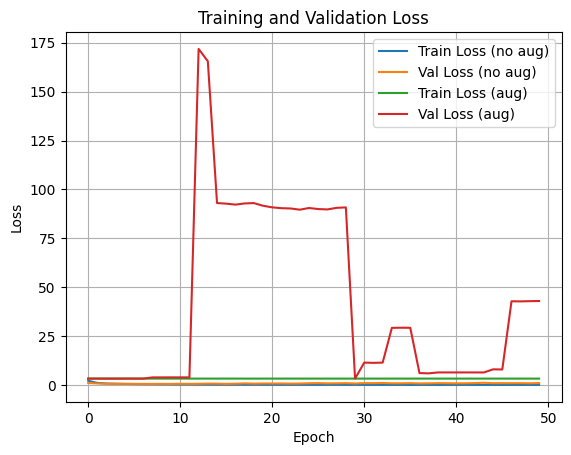

In [9]:
plt.plot(history.history['loss'], label='Train Loss (no aug)')
plt.plot(history.history['val_loss'], label='Val Loss (no aug)')
plt.plot(history_aug.history['loss'], label='Train Loss (aug)')
plt.plot(history_aug.history['val_loss'], label='Val Loss (aug)')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training and Validation Loss')
plt.legend(); plt.grid(True); plt.savefig('loss_curve.png'); plt.show()

## 📊 9. Evaluate on Test Set and Save Results

In [10]:
y_pred = np.argmax(model_aug.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
acc_per_class = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(acc_per_class):
    print(f'Letter {i}: {acc:.2f}')
print('Average accuracy:', acc_per_class.mean())
pd.DataFrame(cm).to_csv('confusion_matrix.csv', index=False)
with open('results.txt', 'w') as f:
    f.write('Letter    Accuracy\n')
    for i, acc in enumerate(acc_per_class):
        f.write(f'{i:<10}{acc:.4f}\n')
    f.write(f'\nAverage accuracy: {acc_per_class.mean():.4f}\n')

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Letter 0: 0.05
Letter 1: 0.00
Letter 2: 0.00
Letter 3: 0.00
Letter 4: 0.00
Letter 5: 0.00
Letter 6: 0.00
Letter 7: 0.00
Letter 8: 0.00
Letter 9: 0.00
Letter 10: 0.00
Letter 11: 0.00
Letter 12: 0.00
Letter 13: 0.00
Letter 14: 0.00
Letter 15: 0.00
Letter 16: 0.00
Letter 17: 0.00
Letter 18: 0.00
Letter 19: 0.00
Letter 20: 0.00
Letter 21: 0.00
Letter 22: 0.00
Letter 23: 0.00
Letter 24: 0.00
Letter 25: 0.00
Letter 26: 0.00
Average accuracy: 0.001851851851851852
